In this example, we will compare stop loss orders and trailing stop orders for different stop values.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import itertools
import yfinance as yf

In [3]:
# Define your params here
INVESTMENT = 100 # in $
COMMISSION = 0.0025 # in %
STOPS = np.arange(0, 0.3, 0.0001)
ASSET_NAME = 'MSFT'

In [4]:
# Download data
ticker = yf.Ticker(ASSET_NAME)
history = ticker.history(period="max")

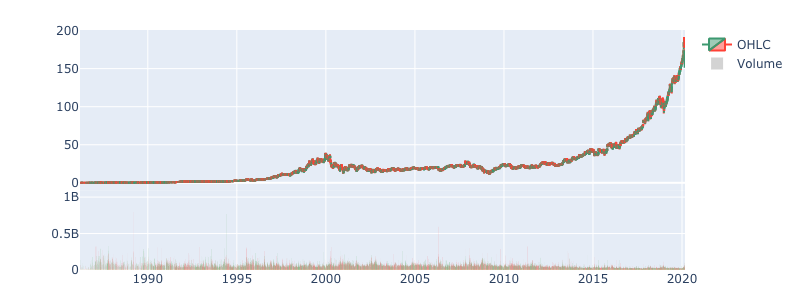

In [5]:
ohlcv = vbt.OHLCV.from_df(history)

ohlcv.plot(index=history.index).show_png()

In [6]:
# Define your basic strategy here (must be of shape (n, 1))
FAST_WINDOW = 30
SLOW_WINDOW = 80

dmac = vbt.DMAC(ohlcv.open, FAST_WINDOW, SLOW_WINDOW)
dmac_entries, dmac_exits = dmac.crossover_signals()

print(dmac_entries.shape, dmac_exits.shape)

(8562, 1) (8562, 1)


/Users/olegpolakow/Documents/SourceTree/vectorbt copy/vectorbt/strategy.py:85: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt copy/vectorbt/strategy.py:88: RuntimeWarning:

invalid value encountered in less



## StopLoss

In [7]:
# Calculate stop loss exits for each stop in STOPS
stoploss_exits = dmac_entries.generate_stoploss_exits(ohlcv.open, STOPS)

print(stoploss_exits.shape)

(8562, 3000)


In [8]:
# Combine strategy exits and StopLoss exits
stoploss_exits = dmac_exits | stoploss_exits

print(stoploss_exits.shape)

(8562, 3000)


In [15]:
stoploss_portfolio = vbt.Portfolio.from_signals(
    ohlcv.open, dmac_entries, stoploss_exits, investment=INVESTMENT, commission=COMMISSION)

## TrailingStop

In [10]:
# Calculate trailing stop exits for each stop in STOPS
trailstop_exits = dmac_entries.generate_trailstop_exits(ohlcv.open, STOPS)

print(trailstop_exits.shape)

(8562, 3000)


In [11]:
# Combine strategy exits and TrailingStop exits
trailstop_exits = dmac_exits | trailstop_exits

print(trailstop_exits.shape)

(8562, 3000)


In [12]:
trailstop_portfolio = vbt.Portfolio.from_signals(
    ohlcv.open, dmac_entries, trailstop_exits, investment=INVESTMENT, commission=COMMISSION)

## Evaluation

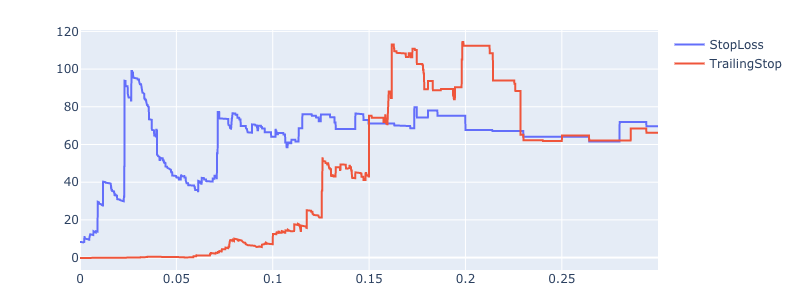

In [16]:
vbt.Scatter(data_labels=['StopLoss', 'TrailingStop'], x_labels=STOPS, data=np.vstack((
    stoploss_portfolio.total_return,
    trailstop_portfolio.total_return
))).show_png()

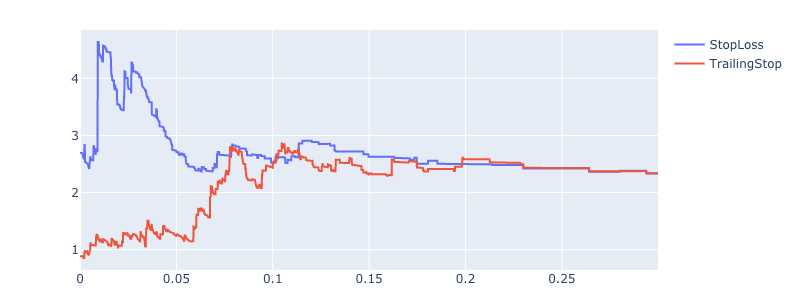

In [17]:
vbt.Scatter(data_labels=['StopLoss', 'TrailingStop'], x_labels=STOPS, data=np.vstack((
    stoploss_portfolio.profit_factor,
    trailstop_portfolio.profit_factor
))).show_png()